# Import Libs

In [38]:
import warnings
warnings.filterwarnings("ignore")

# Import general functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import lib for saving model and encoder
import os
import pickle

# Import preprocessing functions
from sklearn.tree               import plot_tree
from sklearn.tree               import export_graphviz
from sklearn.utils              import shuffle
from sklearn.preprocessing      import LabelEncoder
from sklearn.model_selection    import train_test_split

# Import confusion_matrix and roc_auc_curve
from sklearn import metrics

# Import metrics functions
from sklearn.metrics import f1_score,                           \
                            r2_score,                           \
                            recall_score,                       \
                            accuracy_score,                     \
                            precision_score,                    \
                            mean_squared_error,                 \
                            mean_absolute_error,                \
                            balanced_accuracy_score,            \
                            precision_recall_fscore_support
                            

In [39]:
build_path = "build_files/"

# Preprocessing

In [40]:
# Import dataset
data = pd.read_excel('src/dataset_2021 -14.xlsx')
data = shuffle(data)

# Define minimal mark
min_mark = 4

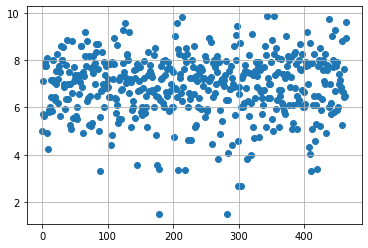

In [41]:
# Output distribution of scores
plt.scatter(
    range(len(data['Средний балл'])), 
    data['Средний балл']
    )
plt.grid()

NOTE: lines in graph illustrate custom increase the number of not pass students.
That trick were done for better model training. It helps to increase accuracy metricks of models

Lets find out how many students did not pass the exams

In [42]:
def counter_print():
    passed = 0
    not_passed = 0
    res = 0
    for mark in data['Средний балл']:
        if mark >= min_mark:
            passed += 1
        elif mark < min_mark:
            not_passed += 1
        res += 1
    print(f"TOTAL: {res}\nPassed: {passed}\nNot pas: {not_passed}")


counter_print()

TOTAL: 465
Passed: 451
Not pas: 14


In [43]:
# Replase mark of student by belonging to the class of successfully passed
data['Сдал'] = pd.cut(x=data['Средний балл'], bins=[0, min_mark, 10], labels=[0, 1])
data.drop(['Средний балл'], axis = 1, inplace= True)

# Drop indicators which are not connected with extracurricular activities
data.drop([
            'Дата прохождения теста',
            '15.Образование Ваших родителей?', 
            '3.С какими оценками Вы закончили школу?',
            '4.Ходили ли Вы на подготовительные курсы перед поступлением в вуз?',
            '7.Какая у Вас семья?',
            '10.Получали ли Вы стипендию? (в течение последнего года)',
            '11.Оцените, как Вам нравится учиться?',
            '13.На какие средства Вы живете?',
            '5.Брали ли Вы академический отпуск?',
            '17.Укажите Ваше семейное положение.',
            '12.Каковы условия Вашего проживания?'
            ],
            axis = 1, inplace = True)

# That part index all names for privacy reasons
name_hash = []
for idx, name in enumerate(data['Учащийся']):
    name_hash.append((idx, name))
    data.loc[idx,'Учащийся'] = idx

Dataset with concern questions

In [44]:
# Create a copy of dataset to use it in future work
debug_data = data

data.head()

,Учащийся,16.Работаете ли Вы?,14.Увлекаетесь ли Вы спортом?,9.Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?,8.Как много Вы пропускаете аудиторных занятий?,6.Бывают ли у Вас долги по экзаменам/зачетам?,"2.Посещаете ли Вы дополнительные занятия (неважно, в вышке или вне)?",1.Участвуете ли Вы в олимпиадах?,Сдал
76,76,Нет,"да, хожу на фитнес или в тренажерный зал;да, з...",Более 3 часов в день,Среднее количество пропусков,Нет,"да, по иностранным языкам","Нет, но собираюсь в этом году",1
304,304,Нет,"да, хожу на фитнес или в тренажерный зал",Все свободное время;Более 3 часов в день,Не пропускаете,1-2 раза в год,"да, по основным предметам моей специальности;д...",Нет,1
98,98,Нет,"нет, не занимаюсь;Другой ответ",От 1 до 3 часов в день,Не пропускаете,1-2 раза в семестр,"да, по основным предметам моей специальности",Да,1
335,335,Нет,"нет, не занимаюсь",От 1 до 3 часов в день,Среднее количество пропусков,Нет,нет,Нет,1
188,188,Нет,"да, занимаюсь командными видами спорта (футбол...",От 1 до 3 часов в день,Не пропускаете,Нет,нет,Нет,1


Split our data in 3 parts for train, test and validation

In [45]:
def create(path):
    if not os.path.exists(path):
        os.mkdir(path)

In [46]:
def train_test_val_split(test_ratio, validation_ratio):
# Replace all text output to index
    label_encoder = LabelEncoder()
    label_data = data.copy()
    s = (label_data.dtypes == 'object')
    object_cols = list(s[s].index)
    create(build_path)
    for col in object_cols:
        label_encoder.fit(label_data[col])
        label_data[col] = label_encoder.transform(label_data[col])
        # Save lable encouder hash to separate files to use them in future if need
        file_name = f'{build_path}/{col.replace("/", "-")}_class_linear_encoder.npy'
        f = open(file_name, 'w+')
        np.save(file_name, label_encoder.classes_)
        f.close()

# Split dataset
    # NOTE: To fix split selections use random_state= parameter
    size = label_data.shape[0]
    validation_ratio = (validation_ratio * size) / (size * (1 - test_ratio))

    X_train, X_test, y_train, y_test = train_test_split(label_data.drop('Сдал', axis = 1), 
                                                        label_data['Сдал'], 
                                                        test_size=test_ratio)

    X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                      y_train, 
                                                      test_size=validation_ratio)

    # Output X_train.iloc[:,1:] delete student hash from training and testing selections
    return X_train.iloc[:,1:], X_test.iloc[:,1:], X_val, y_train, y_test, y_val

In [47]:
X_train, X_test, X_val, y_train, y_test, y_val = train_test_val_split(test_ratio=0.25, validation_ratio=0.05)

In [48]:
X_train

,16.Работаете ли Вы?,14.Увлекаетесь ли Вы спортом?,9.Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?,8.Как много Вы пропускаете аудиторных занятий?,6.Бывают ли у Вас долги по экзаменам/зачетам?,"2.Посещаете ли Вы дополнительные занятия (неважно, в вышке или вне)?",1.Участвуете ли Вы в олимпиадах?
223,1,15,0,0,3,3,0
143,1,15,2,0,1,3,1
302,1,15,2,2,1,7,1
296,1,15,2,0,3,7,1
443,1,15,2,0,1,7,1
...,...,...,...,...,...,...,...
115,1,15,2,0,3,3,1
13,1,15,2,0,3,7,1
346,1,21,10,2,3,7,1
184,1,15,10,0,3,7,1


# Model variants
In that part I will choose the classification model which will predict if student pass exams successfully or not

## Metrics Functions

In [49]:
def classification_quality(y_test, y_pred):
    print("Accuracy:",          accuracy_score(y_test, y_pred))
    print("Recall:",            recall_score(y_test, y_pred, average='macro'))
    print("Precision:",         precision_score(y_test, y_pred, average='macro'))
    print("F1:",                f1_score(y_test, y_pred, average='macro', labels=np.unique(y_pred)))
    print("Weighted Recall:",   (precision_recall_fscore_support(y_test, y_pred, average='macro')))

In [50]:
# For historical reason
def regression_quality(y_test, y_pred):
    print("MSE:",               mean_squared_error(y_test, y_pred))
    print("RMSE:",              mean_squared_error(y_test, y_pred)**(1/2))
    print("MAE:",               mean_absolute_error(y_test, y_pred))
    print("R2:",                r2_score(y_test, y_pred))

In [51]:
metrics_list = ['Accuracy', 'Balanced Accuracy', 'Recall', 'Precision', 'F1', 'MSE', 'RMSE', 'MAE', 'R2']
model_array  = []
output_array = []

def compilance_print(model, y_test, y_pred, model_flag):
    temp_array = []
    if model_flag == 'cls': # Classifier
        temp_array.append(accuracy_score(y_test, y_pred))
        temp_array.append(balanced_accuracy_score(y_test, y_pred))
        temp_array.append(recall_score(y_test, y_pred, average='macro'))
        temp_array.append(precision_score(y_test, y_pred, average='macro'))
        temp_array.append(f1_score(y_test, y_pred, average='macro', labels=np.unique(y_pred)))
        for _ in range(4): temp_array.append(None) # Set regression metrics as None
    
    # For historical reason
    elif model_flag == 'reg': # Regression
        for _ in range(5): temp_array.append(None) # Set classifier metrics as None
        temp_array.append(mean_squared_error(y_test, y_pred))
        temp_array.append(mean_squared_error(y_test, y_pred)**(1/2))
        temp_array.append(mean_absolute_error(y_test, y_pred))
        temp_array.append(r2_score(y_test, y_pred))
    else: 
        print('Error')
        for _ in metrics_list: temp_array.append(None)

    flag = 1
    model_indx = -1
    for indx, _model in enumerate(model_array):
        if _model == model:
            model_indx = indx
            flag = 0
    if flag:
        output_array.append([0]* len(metrics_list))
        model_indx = len(model_array)
        model_array.append(model)
    for indx, el in enumerate(temp_array):
        output_array[model_indx][indx] = el

In [52]:
def graph_show(model, X, y):
    metrics.plot_confusion_matrix(model, X, y)
    metrics.plot_roc_curve(model, X, y)  
    plt.show()

## Classifier

### Perception Classifier Model

In [53]:
from sklearn.linear_model import Perceptron
Perc = Perceptron()
Perc.fit(X_train, y_train)

y_pred = Perc.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('Perceptron', y_test, y_pred, 'cls')

Accuracy: 0.8888888888888888
Recall: 0.7013274336283186
Precision: 0.5673076923076923
F1: 0.5876931417728382
Weighted Recall: (0.5673076923076923, 0.7013274336283186, 0.5876931417728382, None)


### Random Forest Classifier Model

In [54]:
from sklearn.ensemble import RandomForestClassifier
RanF = RandomForestClassifier()
RanF.fit(X_train, y_train)

y_pred = RanF.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('RandomForest', y_test, y_pred, 'cls')

Accuracy: 0.9829059829059829
Recall: 0.75
Precision: 0.991304347826087
F1: 0.8289473684210527
Weighted Recall: (0.991304347826087, 0.75, 0.8289473684210527, None)


### DecisionTreeClassifier Model

Accuracy: 0.9487179487179487
Recall: 0.7323008849557522
Precision: 0.6576576576576576
F1: 0.6866071428571429
Weighted Recall: (0.6576576576576576, 0.7323008849557522, 0.6866071428571429, None)
zsh:1: command not found: dot


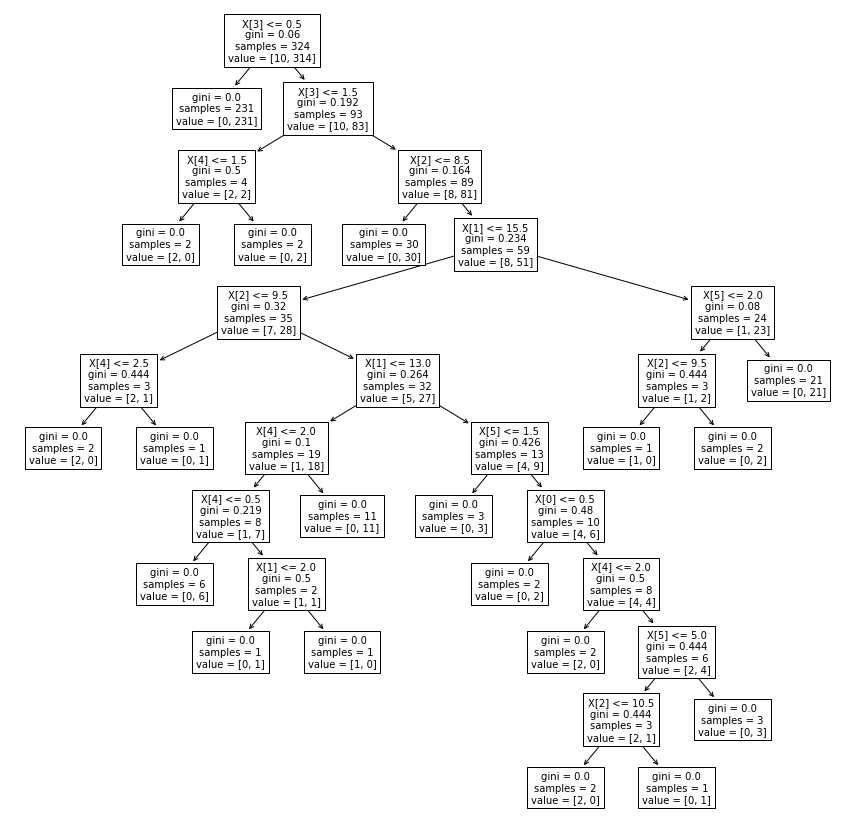

In [55]:
from sklearn.tree import DecisionTreeClassifier
dtr = DecisionTreeClassifier()
dtr.fit(X_train, y_train)

y_pred = dtr.predict(X_test)

# plot tree
plt.figure(figsize=(15,15))
plot_tree(dtr, fontsize=10)

classification_quality(y_test, y_pred)
compilance_print('DecisionTreeClassifier', y_test, y_pred, 'cls')


# Creates dot file named tree.dot
export_graphviz(
            dtr,
            out_file =  "myTreeName.dot",
            feature_names = list(X_train.columns),
            class_names = ['Не Сдал', 'Сдал'],
            filled = True,
            rounded = True)
# Convert dot to png
!dot -Tpng myTreeName.dot -o outfile1.png

# Example how to return real values from hash to encode decision tree

In [56]:
def get_dict(input):
    df = input.copy()
    total_zip = {}
    for col in pd.DataFrame(df.iloc[:,1:-1]).columns:
        list_answers = list(set(df[col]))
        encoder = LabelEncoder()
        filename = f"{build_path}/{str(col).replace('/', '-')}_class_linear_encoder.npy" 
        encoder.classes_ = np.load(filename, allow_pickle=True)
        list_encouder = encoder.transform(pd.DataFrame(list_answers))
        total_zip[col] = dict(zip(list_answers, list_encouder))
    return total_zip


def get_answer_by_index(_dict, question, index):
    return list(_dict.get(question).keys())[list(_dict.get(question).values()).index(index)]

In [57]:
get_answer_by_index(get_dict(debug_data), "14.Увлекаетесь ли Вы спортом?", 0)

'Другой ответ'

In [58]:
get_dict(debug_data).get("14.Увлекаетесь ли Вы спортом?").get("Другой ответ")

0

In [59]:
get_dict(debug_data).get("8.Как много Вы пропускаете аудиторных занятий?")

{'Не пропускаете': 0,
 'Среднее количество пропусков': 2,
 'Регулярно пропускаете': 1}

In [60]:
get_dict(debug_data).get("9.Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?")

{'От 1 до 3 часов в день;7 часов в неделю': 11,
 'От 1 до 3 часов в день;Более 3 часов в день': 13,
 'От 1 до 3 часов в день;Более 3 часов в день;Готовлюсь только перед занятиями': 14,
 'Готовлюсь только перед занятиями': 9,
 '7 часов в неделю;Готовлюсь только перед занятиями': 1,
 '7 часов в неделю': 0,
 'Все свободное время;7 часов в неделю': 5,
 'От 1 до 3 часов в день;Готовлюсь только перед занятиями': 15,
 'Все свободное время;Более 3 часов в день': 6,
 'От 1 до 3 часов в день;7 часов в неделю;Готовлюсь только перед занятиями': 12,
 'Все свободное время;Более 3 часов в день;7 часов в неделю': 7,
 'Все свободное время': 4,
 'Все свободное время;Готовлюсь только перед занятиями': 8,
 'Более 3 часов в день;Готовлюсь только перед занятиями': 3,
 'Более 3 часов в день': 2,
 'От 1 до 3 часов в день': 10}

## Matrix
That table helps to understand which model is better for my work

In [61]:
pd.DataFrame(index=model_array, columns=metrics_list, data=output_array).T

,Perceptron,RandomForest,DecisionTreeClassifier
Accuracy,0.888889,0.982906,0.948718
Balanced Accuracy,0.701327,0.75,0.732301
Recall,0.701327,0.75,0.732301
Precision,0.567308,0.991304,0.657658
F1,0.587693,0.828947,0.686607
MSE,None,None,None
RMSE,None,None,None
MAE,None,None,None
R2,None,None,None


# Model result

In [62]:
my_model = dtr  # My own prefix of DecisionTreeClassifier

I decided to use DecisionTree Classifier model due to its metrix

In [63]:
# save the model to disk
filename = f'{build_path}/DecisionTreeClassifier.sav'
pickle.dump(my_model, open(filename, 'wb'))

# Load an existed model from disk to use it in product
#my_model = pickle.load(open(filename, 'rb'))

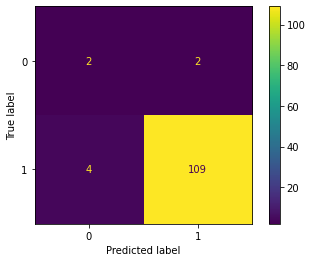

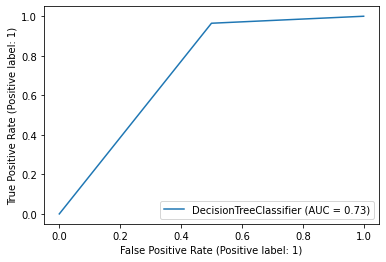

In [64]:
# Output confusion matrix and ROC/AUC curve
graph_show(my_model, X_test, y_test)

That metrics shows the accuracy of model. As we can see that models return very few False-Positive and True-Negative errors

# Validation

In [65]:
# Get predicted results of validation selection
# NOTE: Validation selection was not used for training model thus the results are objective
# Also X_val.iloc[:,1:] used for hiding from model hash of students names
y_pred_val = my_model.predict(X_val.iloc[:,1:])

These functions allow to output results of validation

In [66]:
def print_with_name():
    print(f'Студент {name_hash[X_val.iloc[i, 0]][1]} предположительно {"сдал(а)" if y_pred_val[i] == 1 else "не сдал(а)"}, в жизни {"сдал(а)" if y_val.iloc[i] == 1 else "не сдал(а)"}')

def print_with_id():
    print(f'Студент №{i+1} предположительно {"сдал(а)" if y_pred_val[i] == 1 else "не сдал(а)"}, в жизни {"сдал(а)" if y_val.iloc[i] == 1 else "не сдал(а)"}')

In [67]:
error_counter = 0
total = 0
for i in range(len(y_pred_val)):
    if y_pred_val[i] != y_val.iloc[i] == 1:
        error_counter += 1
    total += 1
    print_with_id()
print(f'There were {error_counter} from {total} error(s)!')

Студент №1 предположительно сдал(а), в жизни сдал(а)
Студент №2 предположительно сдал(а), в жизни сдал(а)
Студент №3 предположительно сдал(а), в жизни сдал(а)
Студент №4 предположительно сдал(а), в жизни сдал(а)
Студент №5 предположительно сдал(а), в жизни сдал(а)
Студент №6 предположительно сдал(а), в жизни сдал(а)
Студент №7 предположительно не сдал(а), в жизни сдал(а)
Студент №8 предположительно сдал(а), в жизни сдал(а)
Студент №9 предположительно сдал(а), в жизни сдал(а)
Студент №10 предположительно сдал(а), в жизни сдал(а)
Студент №11 предположительно сдал(а), в жизни сдал(а)
Студент №12 предположительно сдал(а), в жизни сдал(а)
Студент №13 предположительно сдал(а), в жизни сдал(а)
Студент №14 предположительно сдал(а), в жизни сдал(а)
Студент №15 предположительно сдал(а), в жизни сдал(а)
Студент №16 предположительно не сдал(а), в жизни не сдал(а)
Студент №17 предположительно сдал(а), в жизни сдал(а)
Студент №18 предположительно не сдал(а), в жизни сдал(а)
Студент №19 предположител

# Validation with my answers

In [68]:
my_questions = ["Учащийся", "16.Работаете ли Вы?", "14.Увлекаетесь ли Вы спортом?", 
                "9.Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?",
                "8.Как много Вы пропускаете аудиторных занятий?", "6.Бывают ли у Вас долги по экзаменам/зачетам?", 
                "2.Посещаете ли Вы дополнительные занятия (неважно, в вышке или вне)?", "1.Участвуете ли Вы в олимпиадах?" ]


my_answers =    [
                "Алексей",                                  # Учащийся
                "Да",                                       # 16.Работаете ли Вы?
                "да, хожу на фитнес или в тренажерный зал", # 14.Увлекаетесь ли Вы спортом?
                "Готовлюсь только перед занятиями",         # 9.Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?
                "Не пропускаете",                           # 8.Как много Вы пропускаете аудиторных занятий?
                "Нет",                                      # 6.Бывают ли у Вас долги по экзаменам/зачетам?
                "нет",                                      # 2.Посещаете ли Вы дополнительные занятия (неважно, в вышке или вне)?
                "Нет",                                      # 1.Участвуете ли Вы в олимпиадах?
                ]


df = pd.DataFrame(data=[my_answers], columns=my_questions)

for col in pd.DataFrame(df.iloc[:,1:]).columns:             # Iterate by df without name
    encoder = LabelEncoder()
    filename = f"{build_path}/{str(col).replace('/', '-')}_class_linear_encoder.npy" 
    encoder.classes_ = np.load(filename, allow_pickle=True) # Import encouder fit data
    df[col] = encoder.transform(df[col])


y_pred_my = my_model.predict(df.iloc[:,1:])                 # Without name
print(f'{df.iloc[0,0]} предположительно {"сдал(а)" if y_pred_my == 1 else "не сдал(a)"} экзамен')

Алексей предположительно сдал(а) экзамен


# Correlation matrix

In [69]:
def exists(path):
    try:
        os.stat(path)
    except OSError:
        return False
    return True

In [70]:
# Replace all text output to index
# Used for outputing correlation matrix
label_encoder = LabelEncoder()
label_data = data.iloc[:,1:].copy()

for col in label_data.columns:
    filename = f"{build_path}/{col.replace('/', '-')}_class_linear_encoder.npy"
    if exists(filename):
        label_encoder.classes_ = np.load(filename, allow_pickle=True)
    else: 
        label_encoder.fit(data[col])
#   always:
    label_data[col] = label_encoder.transform(label_data[col])


# Creating correlation matrix
rs = np.random.RandomState(0)
corr = label_data.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None)

,16.Работаете ли Вы?,14.Увлекаетесь ли Вы спортом?,9.Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?,8.Как много Вы пропускаете аудиторных занятий?,6.Бывают ли у Вас долги по экзаменам/зачетам?,"2.Посещаете ли Вы дополнительные занятия (неважно, в вышке или вне)?",1.Участвуете ли Вы в олимпиадах?,Сдал
16.Работаете ли Вы?,1.000000,0.111152,0.016974,-0.166606,0.036611,-0.032890,-0.034068,-0.068922
14.Увлекаетесь ли Вы спортом?,0.111152,1.000000,0.005902,-0.007219,0.015766,0.042920,0.016235,0.033776
9.Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?,0.016974,0.005902,1.000000,0.133477,-0.016581,-0.002256,0.005431,-0.142748
8.Как много Вы пропускаете аудиторных занятий?,-0.166606,-0.007219,0.133477,1.000000,-0.324529,-0.014786,0.019702,-0.274334
6.Бывают ли у Вас долги по экзаменам/зачетам?,0.036611,0.015766,-0.016581,-0.324529,1.000000,0.025066,0.026283,0.143549
"2.Посещаете ли Вы дополнительные занятия (неважно, в вышке или вне)?",-0.032890,0.042920,-0.002256,-0.014786,0.025066,1.000000,0.001888,0.021551
1.Участвуете ли Вы в олимпиадах?,-0.034068,0.016235,0.005431,0.019702,0.026283,0.001888,1.000000,0.038414
Сдал,-0.068922,0.033776,-0.142748,-0.274334,0.143549,0.021551,0.038414,1.000000


# Example of product usage

In [71]:
filename = f'{build_path}/DecisionTreeClassifier.sav'
my_model = pickle.load(open(filename, 'rb'))

my_questions = ["Учащийся", 
                "16.Работаете ли Вы?", 
                "14.Увлекаетесь ли Вы спортом?", 
                "9.Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?",
                "8.Как много Вы пропускаете аудиторных занятий?", 
                "6.Бывают ли у Вас долги по экзаменам/зачетам?", 
                "2.Посещаете ли Вы дополнительные занятия (неважно, в вышке или вне)?", 
                "1.Участвуете ли Вы в олимпиадах?" ]

my_answers = []

for q in my_questions:
    my_answers.append(str(input(f'Введите ответ на вопрос "{q}": ')))

df = pd.DataFrame(data=[my_answers], columns=my_questions)

for col in pd.DataFrame(df.iloc[:,1:]).columns:             # Iterate by df without name
    encoder = LabelEncoder()
    filename = f"{build_path}/{str(col).replace('/', '-')}_class_linear_encoder.npy" 
    encoder.classes_ = np.load(filename, allow_pickle=True) # Import encouder fit data
    df[col] = encoder.transform(df[col])


y_pred_my = my_model.predict(df.iloc[:,1:])                 # Without name
print(f'{df.iloc[0,0]} предположительно {"сдал(а)" if y_pred_my == 1 else "не сдал(а)"} экзамен')

ValueError: y contains previously unseen labels: ''